In [1]:
import numpy as np
import xarray as xr
from xhistogram.xarray import histogram as hist
from thermodynamics import calc_sigmantr
from dask.diagnostics import ProgressBar

In [2]:
# from distributed import Client, LocalCluster, progress
# cluster = LocalCluster(
#     threads_per_worker=8,
#     n_workers=1,
#     dashboard_address=3624,
#     processes=False,
# )
# client = Client(cluster)
# client

In [10]:
rootdir = '/home/ocean_shared_data1/DRAKKAR/ORCA025.L75-GJM189-S/'
config = 'ORCA025.L75-GJM189'
filepath = rootdir+'*/'+config+'_y*m0[234]d*_gridT.nc'
filepath_hgrid = rootdir+'GRID/'+config+'_mesh_hgr.nc'
filepath_zgrid = rootdir+'GRID/'+config+'_mesh_zgr.nc'
lonrange = [-100,30]
latrange = [45,80]

In [11]:
%%time
# Load grid
ds_grid = xr.merge([xr.open_dataset(filepath_hgrid),xr.open_dataset(filepath_zgrid)],compat='override').squeeze()
# Change name of depth variable and drop time_counter
ds_grid = ds_grid.rename({'z':'deptht'}).assign_coords({'deptht':ds_grid.gdept_0.values}).drop('time_counter')
ds_grid = ds_grid

# Load data files
ds_T = xr.open_mfdataset(filepath,combine='by_coords',parallel=True)
# Merge with grid
ds_T = ds_T.update(ds_grid);

CPU times: user 33.4 s, sys: 16.9 s, total: 50.3 s
Wall time: 44.2 s


In [12]:
# Isolate North Atlantic
NAcondition = (ds_T.nav_lon>=lonrange[0]) & (ds_T.nav_lon<=lonrange[1]) & (ds_T.nav_lat>=latrange[0]) & (ds_T.nav_lat<=latrange[1])
ds_T = ds_T.where(NAcondition,drop=True)

In [18]:
Vmld = (ds_T.somxl010*ds_T.e1t*ds_T.e2t).sum(['x','y'])
Vmld.name='Vmld'

In [19]:
with ProgressBar():
    Vmld.to_dataset().to_netcdf('data/processed/eulerian/orca025_NA_Vmld.nc')

[########################################] | 100% Completed |  8.8s


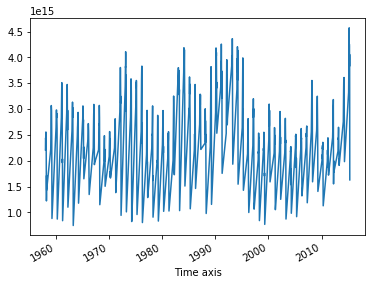

In [16]:
Vmld.plot()